# Portfolio
Brian Howard
7 December 2020

In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(Hmisc)
library(tseries)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
library(gtable)
library(data.table)
library(readxl)
library(IRdisplay)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats'

Define the source of the data (local or web) and whether to update the models.

Call helper functions

In [2]:
source("plotHelper.r")

These functions help organize tables in the document

In [3]:
tblPort <- function(rrData, datay){
  
  df.port <- rrData[[1]][c("string.symbol", "string.description", "date.series.start", "float.expense.ratio",
                      datay, paste(datay, "_Opt", sep = ""))]
  
  string.colnames <- colnames(df.port);
  string.colnames[1] <- "Symbol"
  string.colnames[2] <- "Description"
  string.colnames[3] <- "Series Start"
  string.colnames[4] <- "Expense Ratio (%)"

  kable(rrData[[1]][c("string.symbol", "string.description", "date.series.start", "float.expense.ratio",
                      datay, paste(datay, "_Opt", sep = ""))], digits=c(0,0,3,3,3,3)) %>%
  kable_styling(bootstrap_options = c("striped", "hover"))
  
}


Define the source of the data (local or web) and whether to update the models.

In [4]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [5]:
dt.recent = as.Date("2017-01-01")
string.analysis.start <- "2007-05-22"
iRetPd <- 180
d.GSPC.max = 3500

## Load the data and create the data frame
Load up the off-line data

In [6]:
load("C:/Users/Rainy/OneDrive/RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [7]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [8]:
source("calcInterpolate.r")

In [9]:
df.data <- calcInterpolate(df.data, df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [10]:
df.data <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

## Normalize data
Linearly interpolate the data, add normalized columns (this helps speed portfolio calcs)

In [11]:
for (col_name in names(df.data))
{
    if (is.numeric(df.data[,col_name]))
    {
      # Normalize data
      str.col.norm <- paste(col_name, "_Norm", sep="") 
      d.den = df.data[as.Date(rownames(df.data)) == as.Date(string.analysis.start),col_name]
        if (abs(d.den) > 0.00000001){
            df.data[, str.col.norm] <- df.data[,col_name] / d.den
        }else{
            df.data[, str.col.norm] <- 1
        }
      
        
     # Descriptions must be associated with the root data series name. If the
     # symbol table is empty and there is a "." in the name, look up the root
     # symbol and use that.
     str.symbol.root <- col_name
       if (grepl("\\.", col_name)) {
         str.symbol.root <- substr(col_name, 1, regexpr("\\.", col_name) - 1)
       }
        
      # Add it to the symbols table
      str.desc <- paste(df.symbols$string.description[df.symbols$string.symbol == str.symbol.root], "\nNormalized", sep =
                                       "")
      df.symbols <-
      rbind(
        df.symbols,
        data.frame(
          string.symbol = str.col.norm,
          string.source = "Calc",
          string.description = str.desc,
          string.label.y = "-",
          float.expense.ratio = -1.00,
          date.series.start = df.symbols$date.series.start[df.symbols$string.symbol == str.symbol.root],
          date.series.end = df.symbols$date.series.end[df.symbols$string.symbol == str.symbol.root]
        )
      )
    
    }
}

In [12]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [13]:
source("calcFeatures.r")

In [14]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "GSFTX.Volume has zero or negative values. Log series will be zero."
[1] "LFMIX.Volume has zero or negative values. Log series will be zero."
[1] "LFMCX.Volume has zero or negative values. Log series will be zero."
[1] "LFMAX.Volume has zero or negative values. Log series will be zero."
[1] "LCSIX.Volume has zero or negative values. Log series will be zero."
[1] "VBIRX.Volume has zero or negative values. Log series will be zero."
[1] "VFSUX.Volume has zero or negative values. Log series will be zero."
[1] "LTUIX.Volume has zero or negative values. Log series will be zero."
[1] "PTTPX.Volume has zero or negative values. Log series will be zero."
[1] "NERYX.Volume has zero or negative values. Log series will be zero."
[1] "STIGX.Volume has zero or negative values. Log series will be zero."
[1] "HLGAX.Volume has zero or negative values. Log series will be zero."
[1] "FTRGX.Volume has zero or negative values. Log series 

These are auxilliary series that use the YoY and smoothed data.

In [15]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [16]:
source("calcRecession.r")

Portfolio specific functions

In [17]:
source("calcPort.r")

# Introduction
This is a portfolio analysis, data pulled from yahoo. I’m trying to decide what a better mix would be for this old IRA account. These next few segments load the data into the R program.

## Define the symbols to be used in the analysis.

This code defines stock ticker symbols that will be available for analysis. It includes descriptions and labels for the plots.

The table uses the analysis start date as the series start date to instantiate the data frame. Once the data is pulled down into the zoo object the actual series start data will replace the analyis start.

## Truncate data

A few last calculations to truncate and aggregrate the data

In [18]:
df.data <- with(df.data, df.data[date>=string.analysis.start,])

# Calculate the returns

## Calculate the time based returns on annual basis

In this analysis all the returns are calculated on an annual basis. It means there is a year of dead data, but it eliminates seasonal variation in data (think: Christmas).

## Summarize returns

In constructing the portfolio it is importance to understand the blend of funds. We want maximum returns for minimum volatility. That's not c


In [19]:
# Add normalized columns (this helps speed portfolio calcs)
for (col_name in names(df.data))
{
    if (is.numeric(df.data[,col_name]))
    {

      # Split the name ("USGFG.Close"" is "USGFG"" and "Close"")
      lstSyms <- lstSymSplit(col_name)
        
      # Only if there is two terms
      if( length(lstSyms) > 1){

        if( lstSyms[2] == 'Close_YoY' ){

          # Return is the mean of the series
          df.symbols[df.symbols$string.symbol==lstSyms[1],'ExpReturn'] <- mean(df.data[, col_name])

          # Volatility is the standard deviation of the series.
          df.symbols[df.symbols$string.symbol==lstSyms[1],'Volatility'] <- sd(df.data[, col_name])
          
        }
      }

    }
}



# Define the various portfolios

This code is evaluating ROTH account portfolios. IVOO has a lower expense ratio than MDY, but performance is similar and MDY has a history that goes back to 1995 so I am using MDY as a substitute fo IVOO.

In [20]:
df.symbols$pf_Roth_Legacy <- 0
df.symbols[df.symbols$string.symbol=='VTWO',]$pf_Roth_Legacy <-  0.0000
df.symbols[df.symbols$string.symbol=='VFINX',]$pf_Roth_Legacy <-  0.5051
df.symbols[df.symbols$string.symbol=='TMFGX',]$pf_Roth_Legacy <-  0.0000
df.symbols[df.symbols$string.symbol=='IWM',]$pf_Roth_Legacy <-  0.0001
df.symbols[df.symbols$string.symbol=='QQQ',]$pf_Roth_Legacy <-  0.0001
df.symbols[df.symbols$string.symbol=='HAINX',]$pf_Roth_Legacy <-  0.0001
df.symbols[df.symbols$string.symbol=='VEU',]$pf_Roth_Legacy <-  0.0000


df.symbols$pf_Roth_IRA <- 0
df.symbols[df.symbols$string.symbol=='VTWO',]$pf_Roth_IRA <-  0.0001
df.symbols[df.symbols$string.symbol=='EES',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='IJR',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='VFINX',]$pf_Roth_IRA <-  0.0001
df.symbols[df.symbols$string.symbol=='VOE',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='VOT',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='NOBL',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='VEU',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='IWM',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='QQQ',]$pf_Roth_IRA <-  0.0001
df.symbols[df.symbols$string.symbol=='ONEQ',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='IVOO',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='MDY',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='VO',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='CZA',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='BIL',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='VYM',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='ACWI',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='VEU',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='DJI',]$pf_Roth_IRA <-  0.2000
df.symbols[df.symbols$string.symbol=='RLG',]$pf_Roth_IRA <-  0.2000
df.symbols[df.symbols$string.symbol=='SPY',]$pf_Roth_IRA <-  0.1000
df.symbols[df.symbols$string.symbol=='PRWCX',]$pf_Roth_IRA <-  0.2000
df.symbols[df.symbols$string.symbol=='BSV',]$pf_Roth_IRA <-  0.0000
df.symbols[df.symbols$string.symbol=='BIV',]$pf_Roth_IRA <-  0.0001

# From Dave's e-mail 30 Aug
df.symbols$pf_LPL <- 0
# Fixed income
df.symbols[df.symbols$string.symbol=='VBIRX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='THIIX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='VFSUX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='LTUIX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='PTTPX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='NERYX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='STIGX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='HLGAX',]$pf_LPL <-  1.0/26.0
df.symbols[df.symbols$string.symbol=='FTRGX',]$pf_LPL <-  1.0/26.0

# Inflation hedges
df.symbols[df.symbols$string.symbol=='BFIGX',]$pf_LPL <-  4/26
df.symbols[df.symbols$string.symbol=='GOLD',]$pf_LPL <-  4/26

# Equity/Equity Linked
df.symbols[df.symbols$string.symbol=='GSFTX',]$pf_LPL <-  3/26
df.symbols[df.symbols$string.symbol=='PRWCX',]$pf_LPL <-  3/26
df.symbols[df.symbols$string.symbol=='ADOZX',]$pf_LPL <-  3/26


This part normalizes all the data, in case there is a typo or numerical rounding that results in somthing less than 100%


In [21]:
for (col_name in names(df.symbols)){
  
  if( length(grep('pf_', col_name))){
    df.symbols[,col_name] <- df.symbols[,col_name] / sum(df.symbols[,col_name])
  }
  
}


Update the returns

In [22]:
df.data <- pfUpdateReturn("pf_Roth_Legacy", df.data, df.symbols)
df.data <- pfUpdateReturn("pf_Roth_IRA", df.data, df.symbols)
df.data <- pfUpdateReturn("pf_LPL", df.data, df.symbols)

# Display the portfolios


Display the two portfolios. A great resource for kable formatting: https://haozhu233.github.io/kableExtra/awesome_table_in_html.html

In [23]:
string.colnames <- colnames(df.symbols);
string.colnames[1] <- "Symbol"
string.colnames[2] <- "Source"
string.colnames[3] <- "Description"
string.colnames[4] <- "Label"
string.colnames[5] <- "Expense Ratio (%)"
string.colnames[6] <- "Series Start"
string.colnames[7] <- "Expected Return"

## Legacy portfolio

### Portfolio description

In [24]:
kable(df.symbols[df.symbols$pf_Roth_Legacy > 0.0, ],
      col.names = string.colnames,
      digits = c(0, 0, 0, 0, 2, 0, 2, 2, 3, 3, 3, 4)) %>%
  kable_styling(bootstrap_options = c("striped", "hover")) %>%
  as.character() %>%
  display_html()

,Symbol,Source,Description,Label,Expense Ratio (%),Series Start,Expected Return,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_IRA,pf_LPL
176,VFINX,yahoo,Vanguard 500 Index Investor,Dollars,0.14,1980-01-02,2020-12-03,NA,NA,7.800,15.961,0.9994,0,0
180,IWM,yahoo,iShares Russell 2000,Dollars,0.19,2000-05-26,2020-12-03,NA,NA,6.919,19.065,0.0002,0,0
182,HAINX,yahoo,Harbor International Institutional,Dollars,0.81,1987-12-29,2020-12-03,NA,NA,-0.699,22.766,0.0002,0,0
191,QQQ,yahoo,Invesco QQQ Trust,Dollars,-1.00,1999-03-10,2020-12-03,NA,NA,15.521,18.678,0.0002,0,0


### Time series analysis

This one is performing much worse than I expected. Data in this section is for reference only.

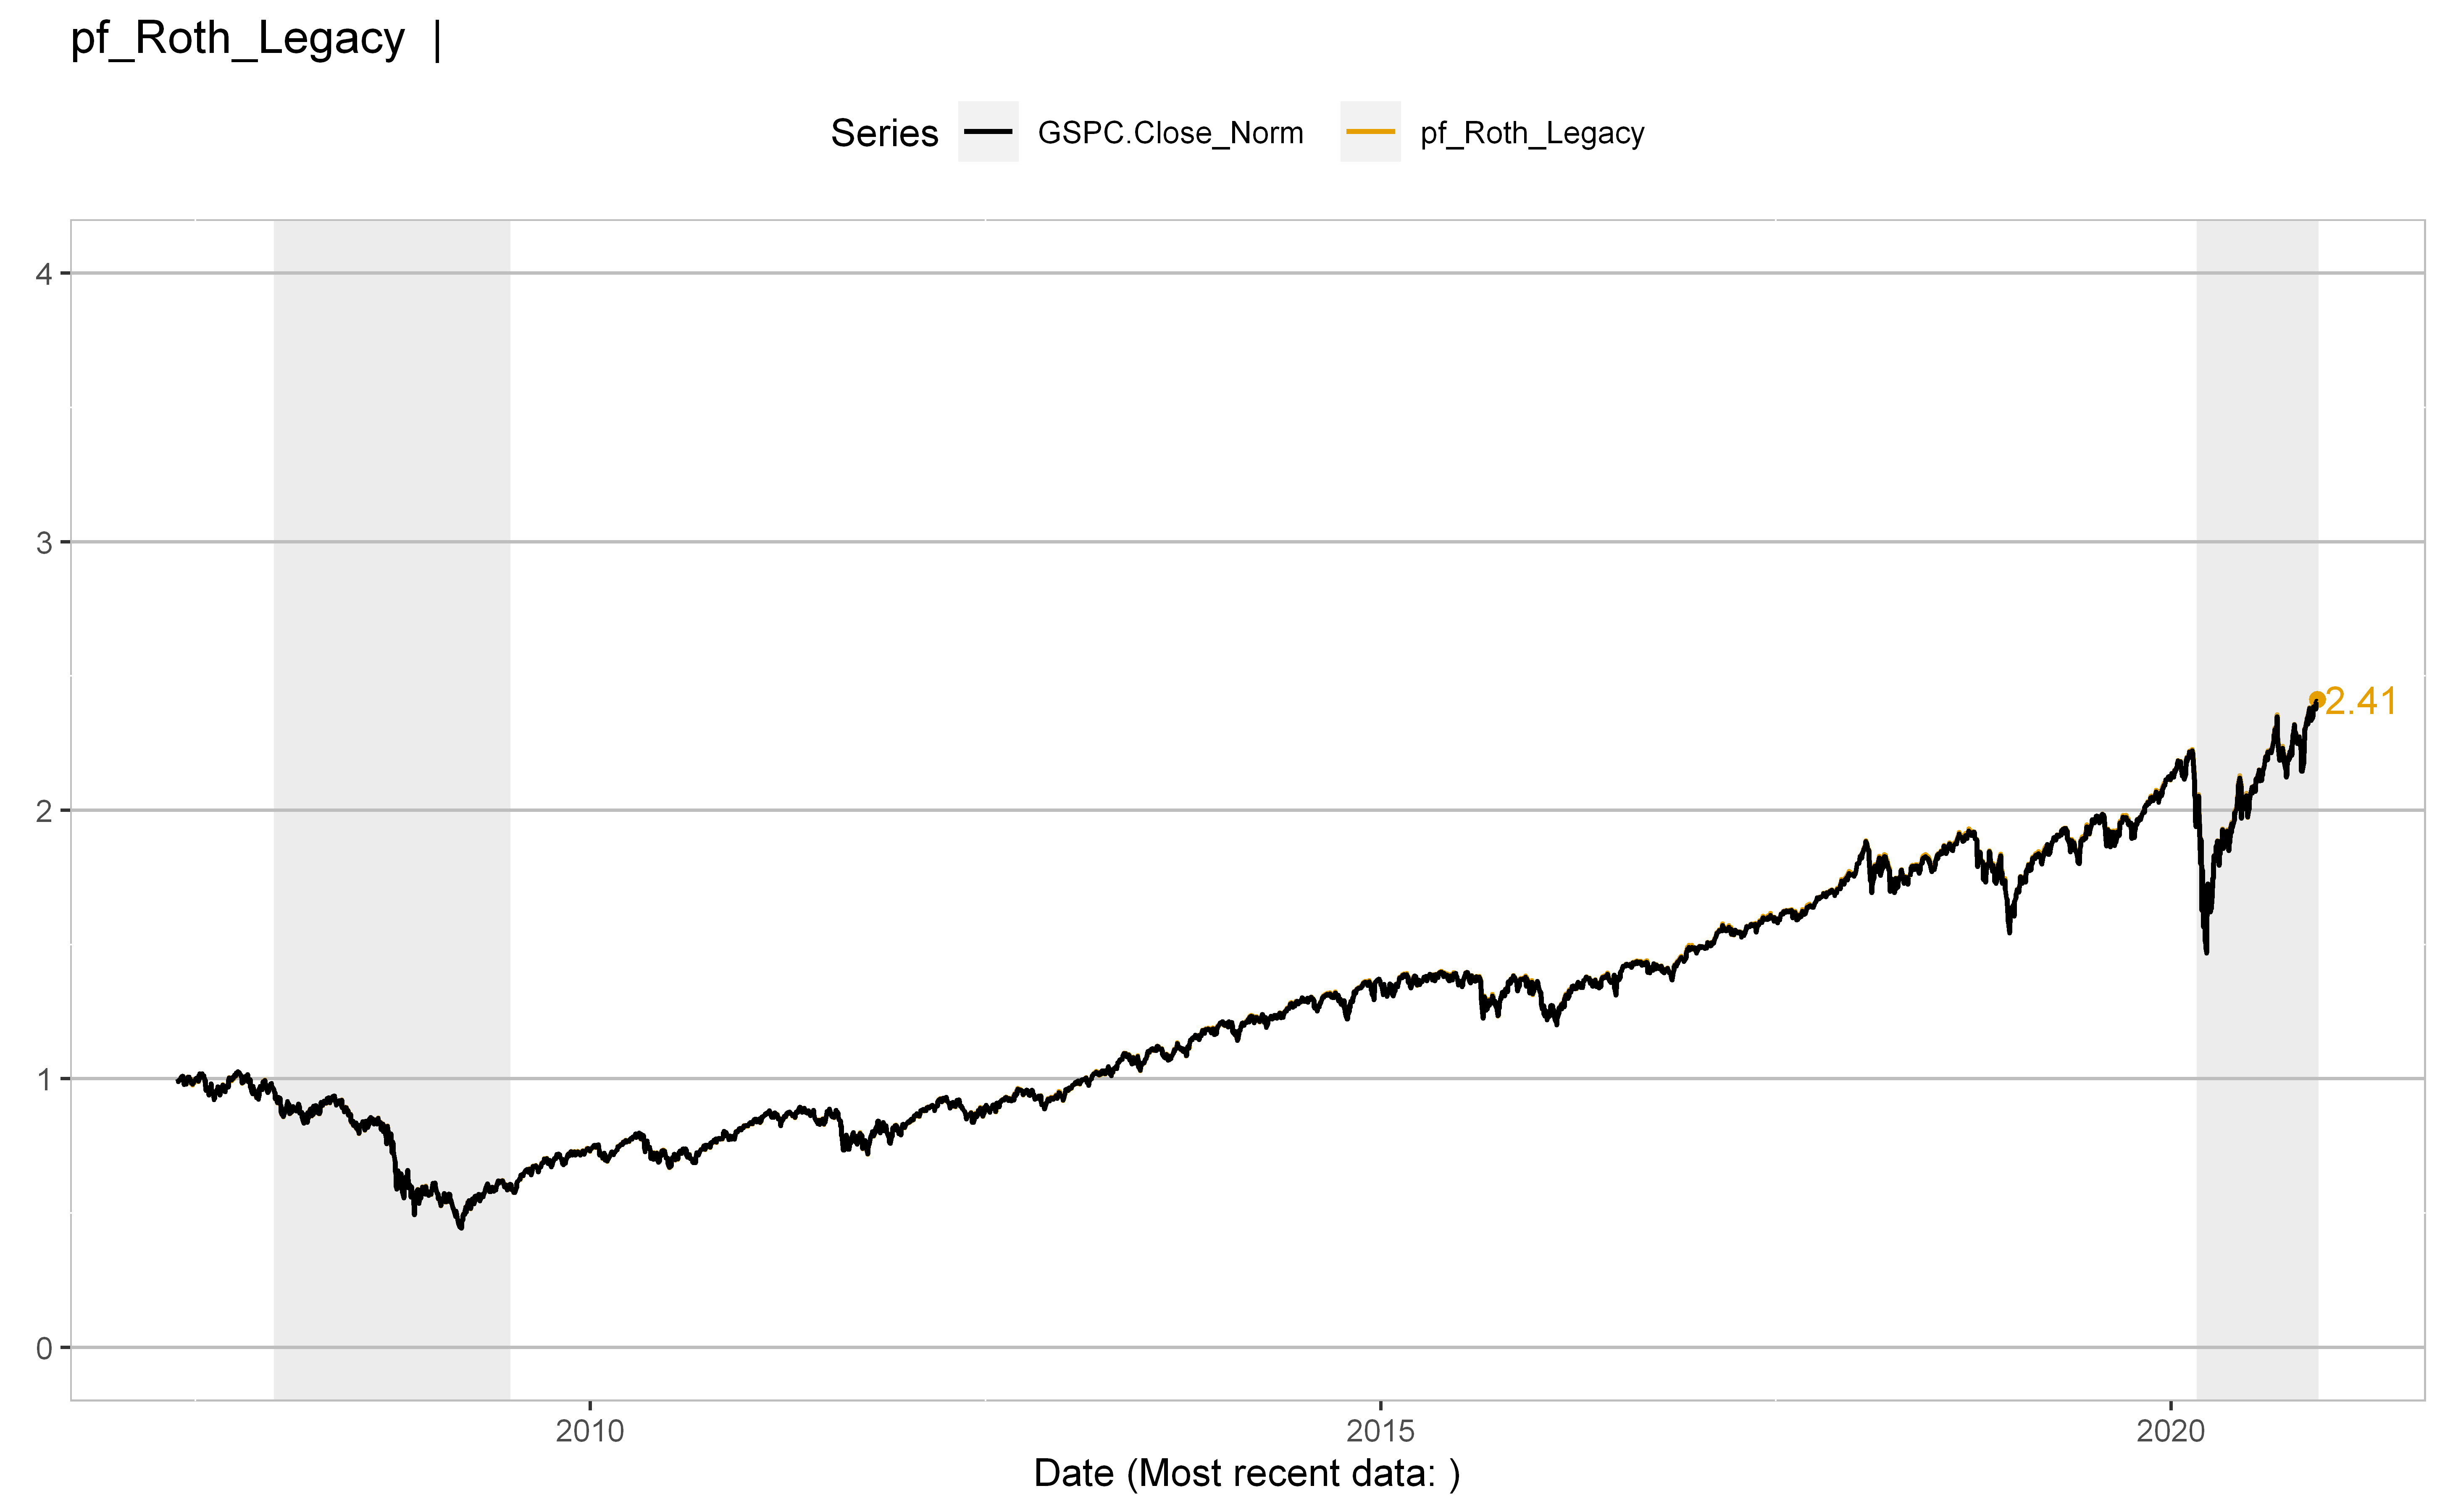

In [25]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay.legacy <- "pf_Roth_Legacy"
ylim <- c(0, 4)
plotSingleBench(dfRecession, datay.legacy, ylim, df.symbols, df.data, string.analysis.start)

### Risk return analysis

This section plots the funds on return and volatility axis. An ideal fund would be in the upper left corner of the plot.

In [26]:
rrData.legacy <- plotReturnVolatility(datay.legacy, df.data, df.symbols)

[1] "Volatility:  15  |  25"
[1] "Returns:  -5  |  25"


In [27]:
string.portfolio.in <- datay.legacy
df.data.in <- df.data
df.symbols.in <- df.symbols

In [28]:
    # Setup a local dataframe with the symbols in the portfolio
    dfRR <- df.symbols.in[df.symbols.in[string.portfolio.in] > 0, ]

In [29]:
    # Need a data table with just the ticker and data
    strCols <-
      paste(dfRR$string.symbol, ".Close_Norm_YoY", sep = "")
    dfPort <- data.table(df.data.in[, strCols])

In [30]:
    # Range of expected returns from the porfolio
    er_vals <-
      seq(
        from = min(dfRR$ExpReturn),
        to = max(dfRR$ExpReturn),
        length.out = 1000
      )

In [31]:
    # find an optimal portfolio for each possible possible expected return
    # (note that the values are explicitly set between the minimum and maximum of
    # the expected returns per asset)
    sd_vals <- rep(0, length(er_vals))
    tryCatch({
      sd_vals <- sapply(er_vals, function(er) {
        op <- portfolio.optim(as.matrix(dfPort), er)
        return(op$ps)
      })
    }, error = function(e) {
      print("Failed to find efficiency boundary")
    })
    
    # Collect in a table
    plot_dt <- data.table(sd = sd_vals, er = er_vals)
    
    # find the lower and the upper frontier
    minsd <- min(plot_dt$sd)
    minsd_er <- plot_dt[sd == minsd, er]
    minsd_er <- minsd_er[1]
    plot_dt[, efficient := er >= minsd_er]

In [32]:
    # Data for the actual portfolio mix
    dfPortRet <- df.data.in[string.portfolio.in]
    strPfYoY <- paste(string.portfolio.in, "_YoY", sep = "")
    dfPortRet[strPfYoY] <-
      CalcYoY(dfPortRet, string.portfolio.in, iRetPd)
    Vol_pf <- sd(dfPortRet[, strPfYoY])
    ExpRet_pf <- mean(dfPortRet[, strPfYoY])
    print(Vol_pf)
    print(ExpRet_pf)

[1] 11.67095
[1] 3.700239


In [33]:
    # Data for the portfolio mix with same returns, but lower volatility
    op_pf <- portfolio.optim(as.matrix(dfPort), ExpRet_pf)
    dfRR[paste(string.portfolio.in, "_Opt", sep = "")] <- op_pf$pw

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."


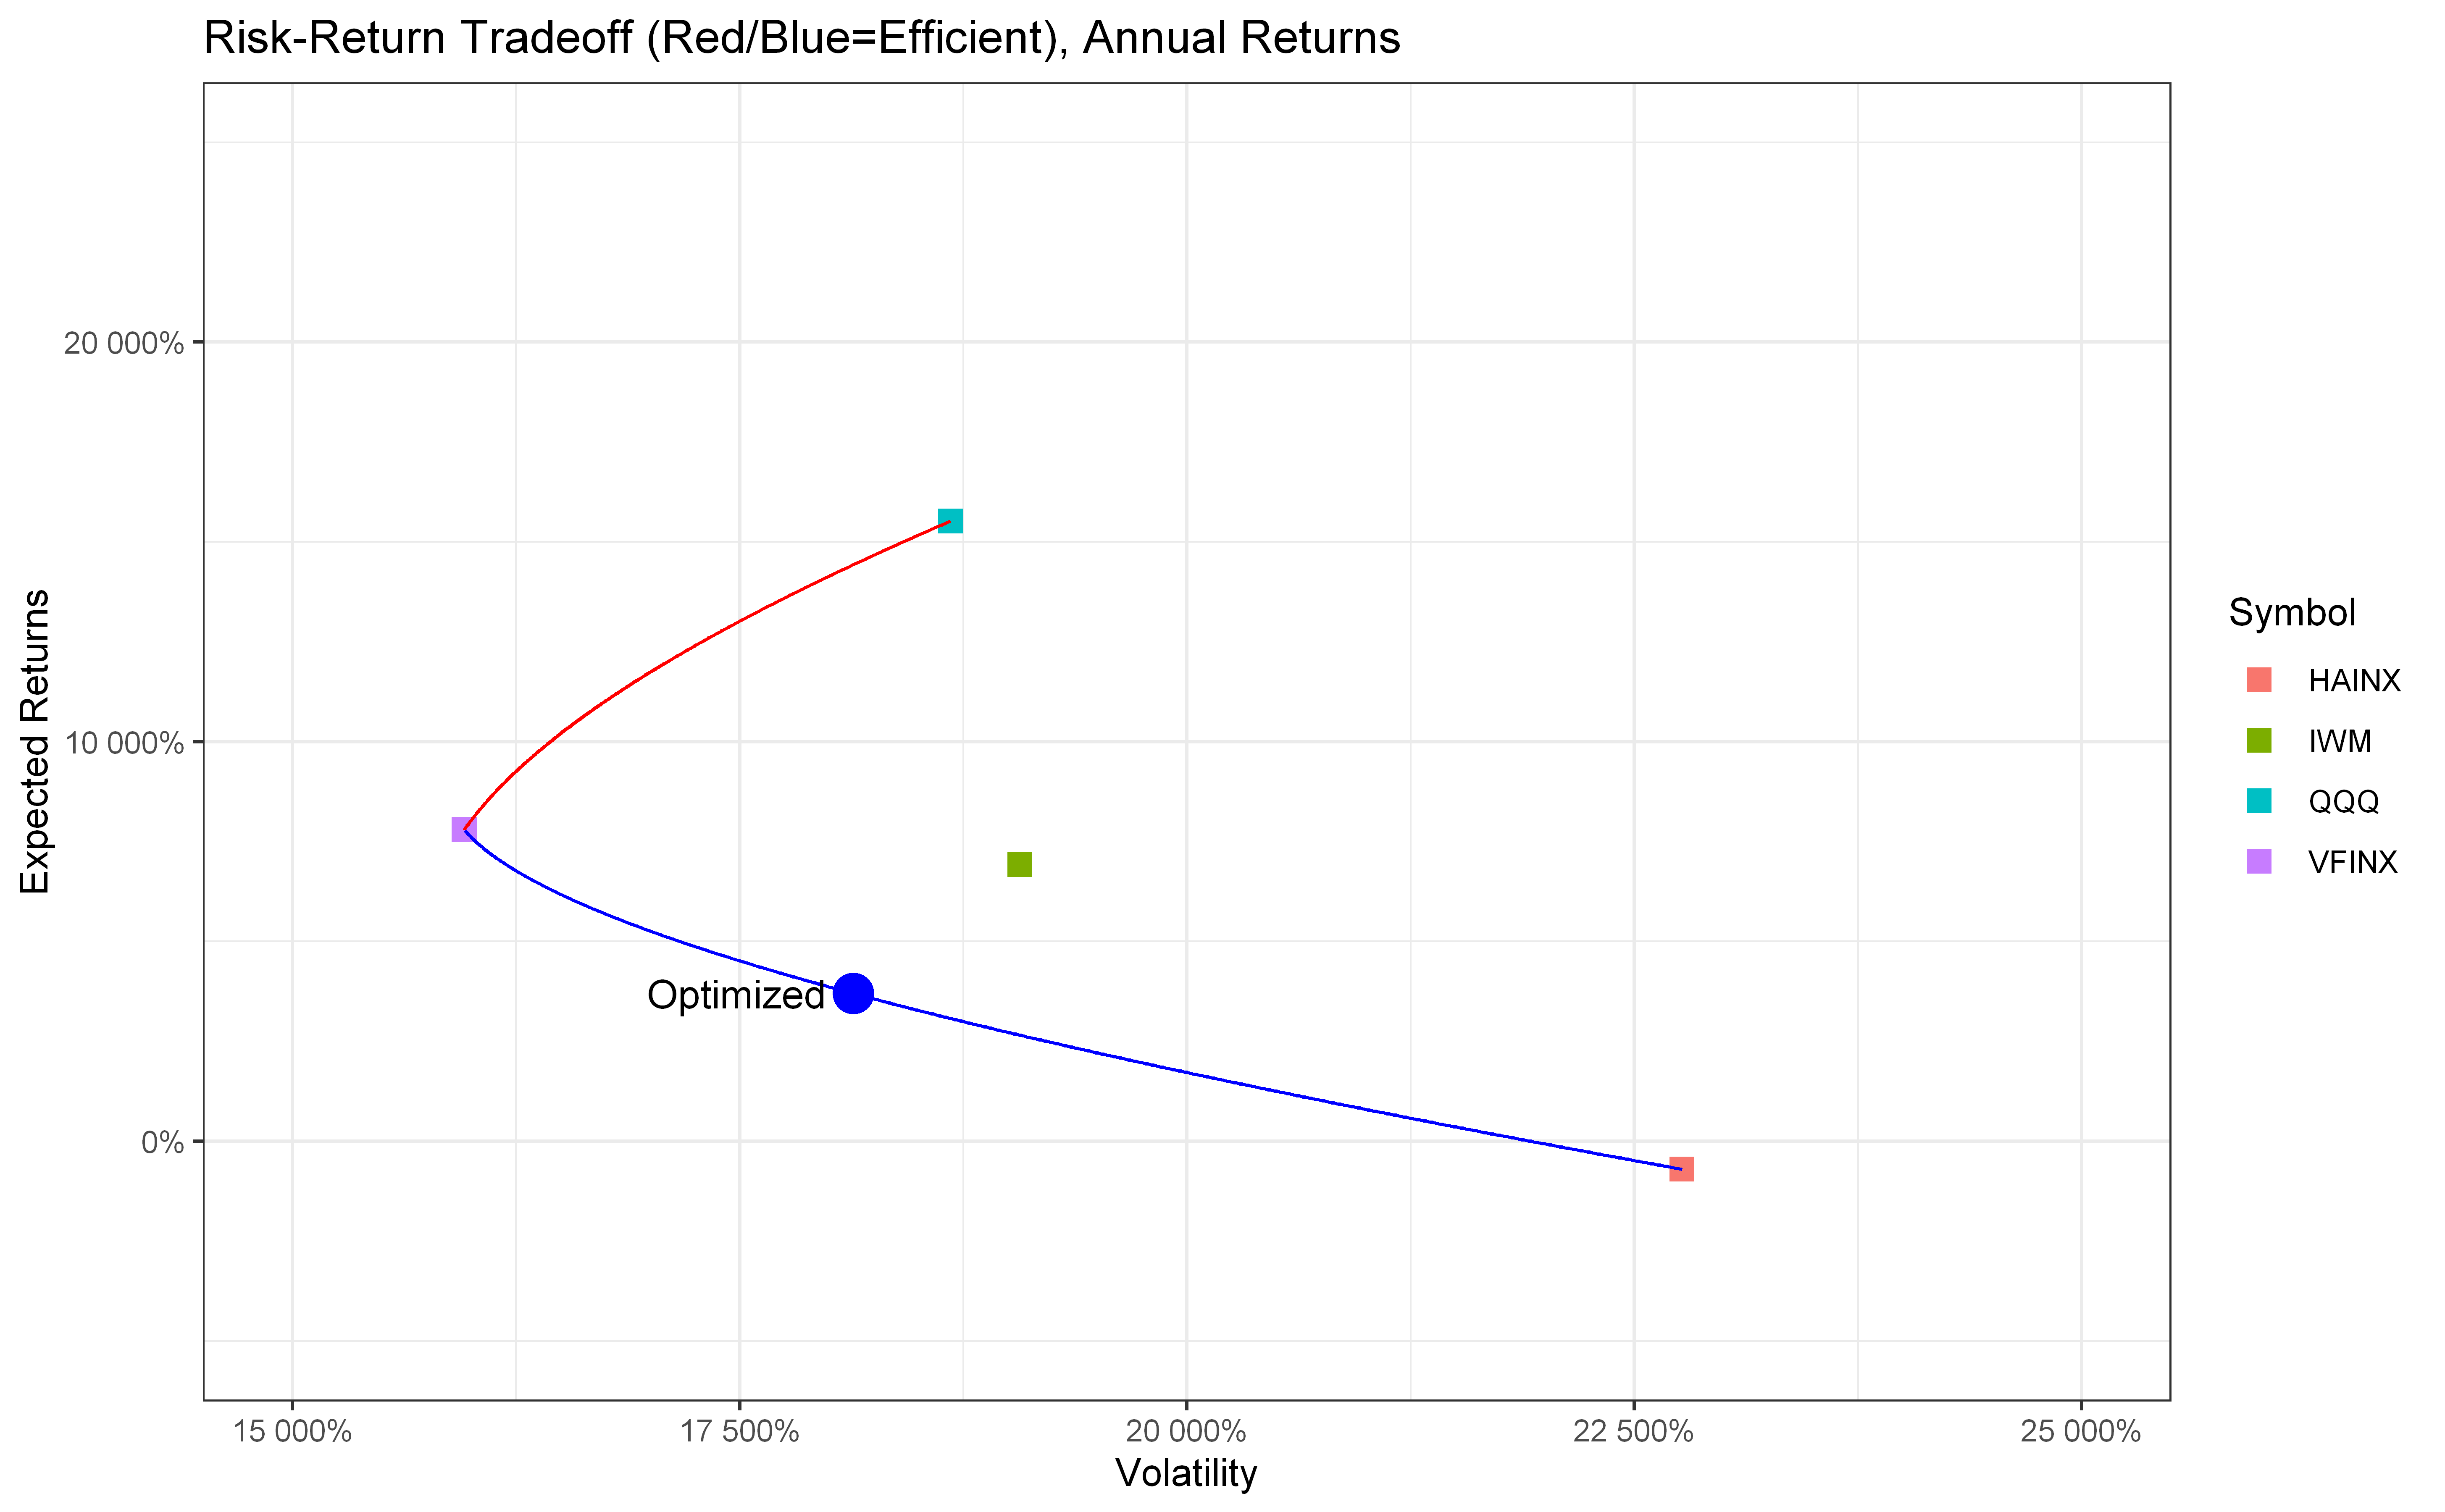

In [34]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
rrData.legacy[[2]]

This table shows the portfolio. Column `r datay.legacy` shows the inputted portfolio and `r paste(datay.legacy,"_Opt", sep="")` shows the portfolio with the same returns, but less risk.

In [35]:
tblPort(rrData.legacy, datay.legacy)  %>%
  as.character() %>%
  display_html()

,string.symbol,string.description,date.series.start,float.expense.ratio,pf_Roth_Legacy,pf_Roth_Legacy_Opt
176,VFINX,Vanguard 500 Index Investor,1980-01-02,0.14,0.999,0.518
180,IWM,iShares Russell 2000,2000-05-26,0.19,0.000,0.000
182,HAINX,Harbor International Institutional,1987-12-29,0.81,0.000,0.482
191,QQQ,Invesco QQQ Trust,1999-03-10,-1.00,0.000,0.000


In [36]:
 df.port <- rrData.legacy[[1]][c("string.symbol", "string.description", "date.series.start", "float.expense.ratio",
                      datay.legacy, paste(datay.legacy, "_Opt", sep = ""))]

In [37]:
rrData.legacy[[1]]

,string.symbol,string.source,string.description,string.label.y,float.expense.ratio,date.series.start,date.series.end,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_IRA,pf_LPL,pf_Roth_Legacy_Opt
,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<date>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
176,VFINX,yahoo,Vanguard 500 Index Investor,Dollars,0.14,1980-01-02,2020-12-03,NA,NA,7.7995132,15.96101,0.9994064108,0.0001427756,0,5.176462e-01
180,IWM,yahoo,iShares Russell 2000,Dollars,0.19,2000-05-26,2020-12-03,NA,NA,6.9189076,19.06536,0.0001978631,0.0000000000,0,9.949063e-17
182,HAINX,yahoo,Harbor International Institutional,Dollars,0.81,1987-12-29,2020-12-03,NA,NA,-0.6989668,22.76606,0.0001978631,0.0000000000,0,4.823538e-01
191,QQQ,yahoo,Invesco QQQ Trust,Dollars,-1.00,1999-03-10,2020-12-03,NA,NA,15.5214457,18.67810,0.0001978631,0.0001427756,0,1.219592e-16


In [38]:
datay.legacy.opt <- "pf_Roth_Legacy_Opt"
df.data <- pfUpdateReturn(datay.legacy.opt, df.data, df.symbols)

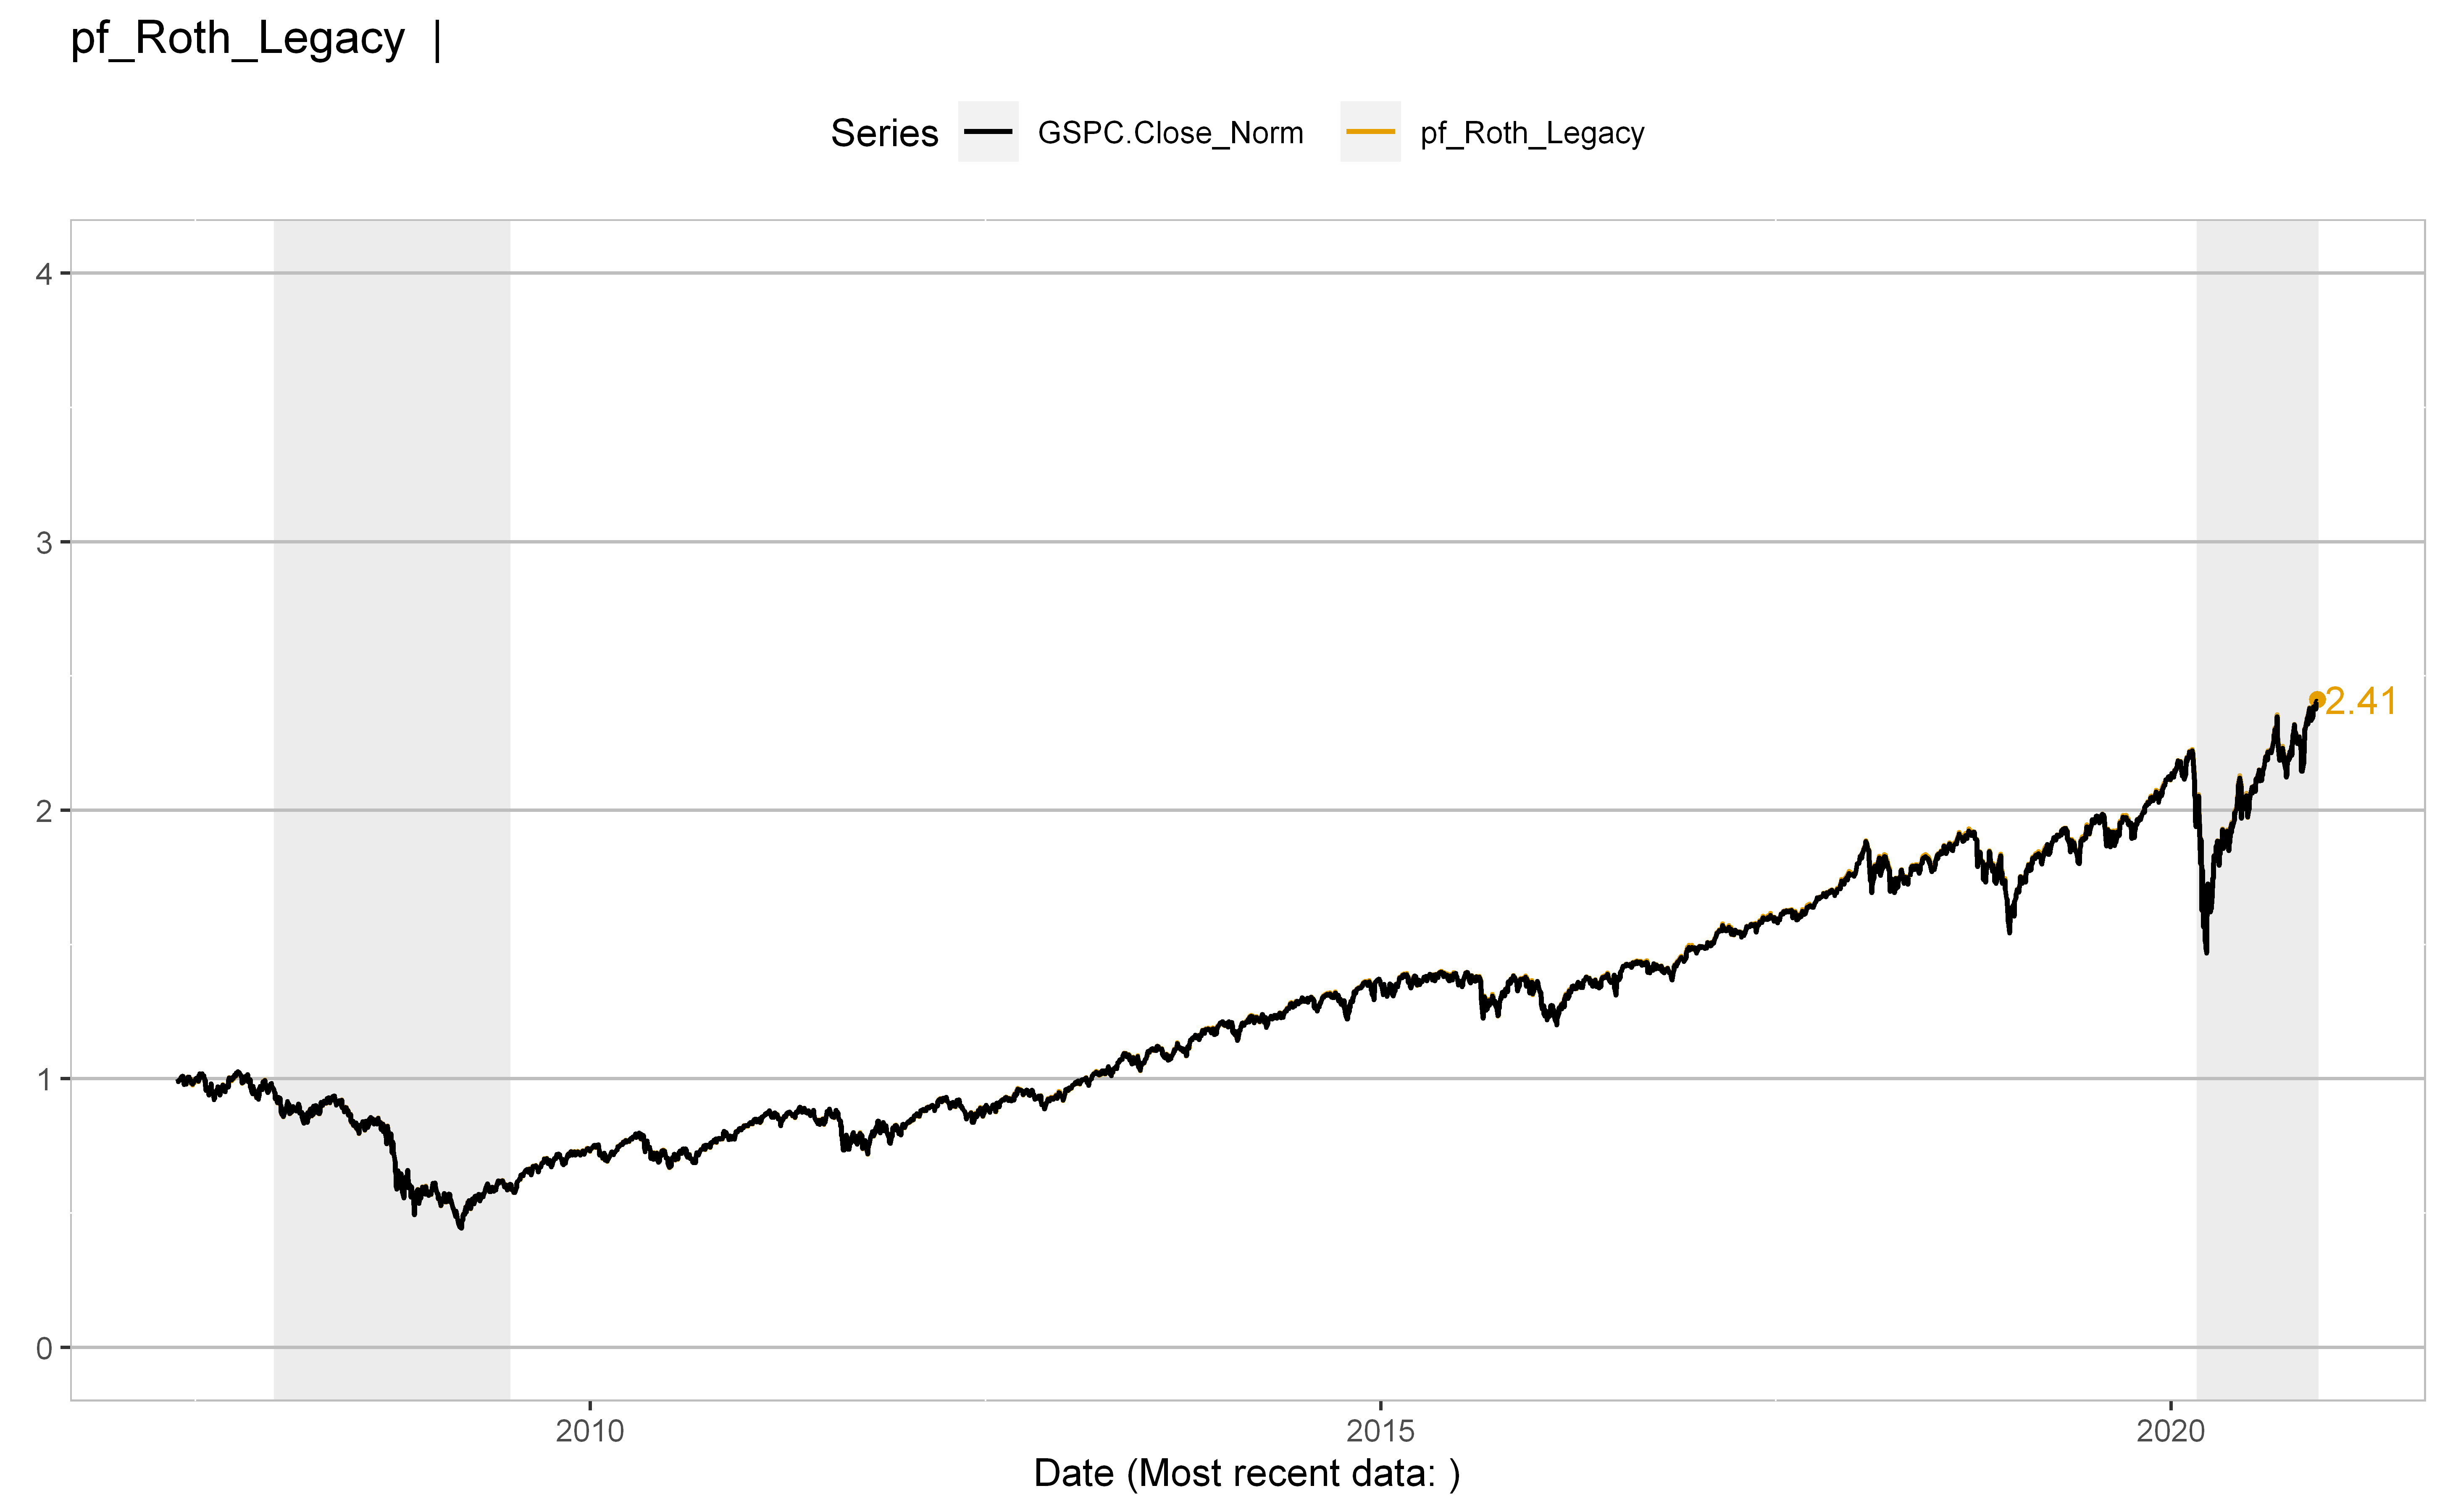

In [39]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
ylim <- c(0, 4)
plotSingleBench(dfRecession, datay.legacy, ylim, df.symbols, df.data, string.analysis.start)

## IRA Roth Portfolio
### Portfolio description

In [40]:
kable(df.symbols[df.symbols$pf_Roth_IRA > 0.0, ],
      col.names = string.colnames,
      digits = c(0, 0, 0, 0, 2, 0, 2, 2, 3, 3)) %>%
  kable_styling(bootstrap_options = c("striped", "hover")) %>%
  as.character() %>%
  display_html()

,Symbol,Source,Description,Label,Expense Ratio (%),Series Start,Expected Return,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_IRA,pf_LPL
25,BIV,yahoo,Vanguard Intermediate-term Bond Index Fund ETF Shares,Dollars,0.05,2007-04-10,2020-12-03,NA,NA,1.555,4,0,0,0
36,VTWO,yahoo,Vanguard Russell 2000 Index Fund ETF Shares,Dollars,0.10,2010-09-22,2020-12-03,NA,NA,7.111,13,0,0,0
40,PRWCX,yahoo,T. Rowe Price Capital Appreciation Fund,Dollars,0.70,1986-06-30,2020-12-03,NA,NA,3.822,13,0,0,0
96,RLG,yahoo,Russell 1000 Growth ETF,Dollars,-1.00,2002-09-30,2020-12-03,NA,NA,11.283,17,0,0,0
97,DJI,yahoo,Dow Jones Industrial Average,Dollars,-1.00,1985-01-29,2020-12-03,NA,NA,7.303,15,0,0,0
171,SPY,yahoo,SPDR S&P 500 ETF,Dollars,-1.00,1993-01-29,2020-12-03,NA,NA,7.760,16,0,0,0
176,VFINX,yahoo,Vanguard 500 Index Investor,Dollars,0.14,1980-01-02,2020-12-03,NA,NA,7.800,16,1,0,0
191,QQQ,yahoo,Invesco QQQ Trust,Dollars,-1.00,1999-03-10,2020-12-03,NA,NA,15.521,19,0,0,0


### Time series analysis

In [41]:
df.symbols

string.symbol,string.source,string.description,string.label.y,float.expense.ratio,date.series.start,date.series.end,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_IRA,pf_LPL
<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<date>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CPIAUCSL,FRED,Consumer Price Index for All Urban Consumers: All Items,Index 1982-1984=100,-1.00,1947-01-01,2020-10-01,TRUE,TRUE,NA,NA,0,0.0000000000,0.00000000
USREC,FRED,NBER based Recession Indicators,+1 or 0,-1.00,1854-12-01,2020-11-01,TRUE,TRUE,NA,NA,0,0.0000000000,0.00000000
UNRATE,FRED,Civilian Unemployment Rate U-3,Percent,-1.00,1948-01-01,2020-11-01,TRUE,FALSE,NA,NA,0,0.0000000000,0.00000000
CCSA,FRED,Continued Claims (Insured Unemployment),Number,-1.00,1967-01-07,2020-11-21,FALSE,FALSE,NA,NA,0,0.0000000000,0.00000000
CCNSA,FRED,"Continued Claims (Insured Unemployment, NSA)",Number,-1.00,1967-01-07,2020-11-21,FALSE,FALSE,NA,NA,0,0.0000000000,0.00000000
NPPTTL,FRED,Total Nonfarm Private Payroll Employment (ADP),Thousands,-1.00,2002-04-01,2020-11-01,TRUE,TRUE,NA,NA,0,0.0000000000,0.00000000
U6RATE,FRED,Total unemployed + margin + part-time U-6,Percent,-1.00,1994-01-01,2020-11-01,TRUE,FALSE,NA,NA,0,0.0000000000,0.00000000
PAYNSA,FRED,All Employees: Total Nonfarm Payrolls (NSA),Thousands of Persons,-1.00,1939-01-01,2020-11-01,TRUE,TRUE,NA,NA,0,0.0000000000,0.00000000
TABSHNO,FRED,"Households and nonprofit organizations; total assets, Level",Billions of Dollars,-1.00,1945-10-01,2020-04-01,TRUE,TRUE,NA,NA,0,0.0000000000,0.00000000


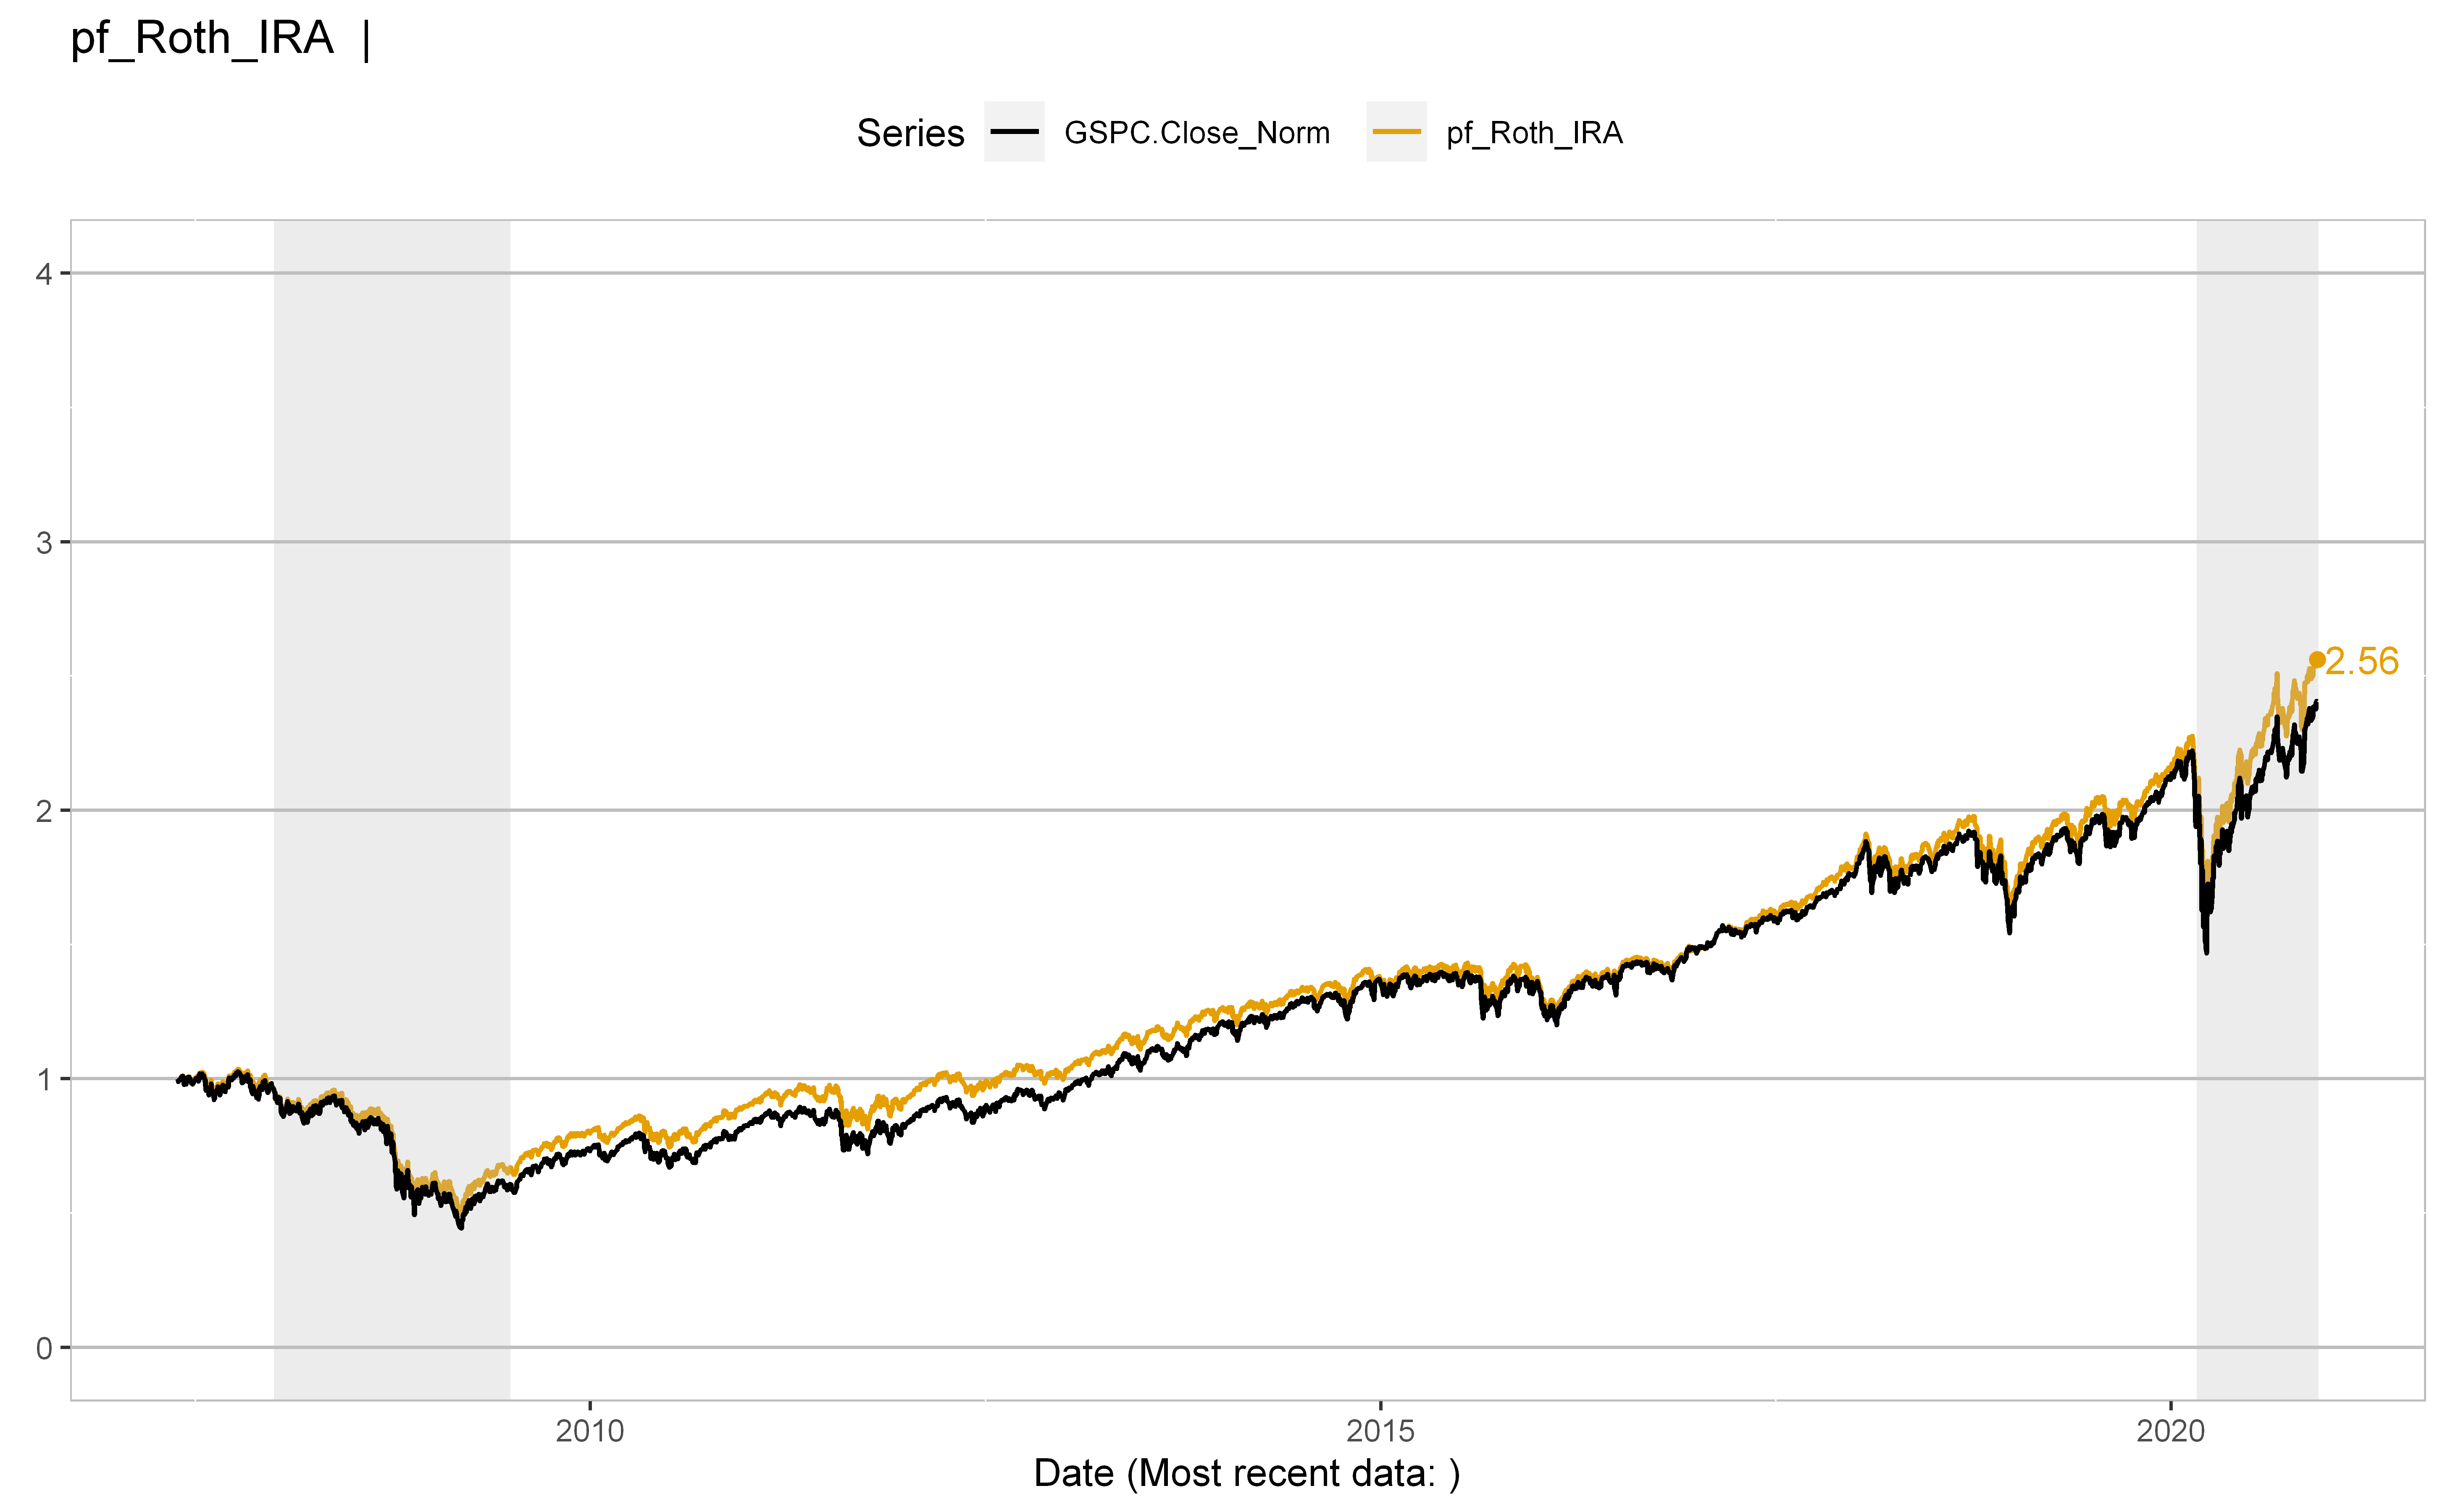

In [42]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay.legacy <- "pf_Roth_IRA"
ylim <- c(0, 4)
plotSingleBench(dfRecession, datay.legacy, ylim, df.symbols, df.data, string.analysis.start)

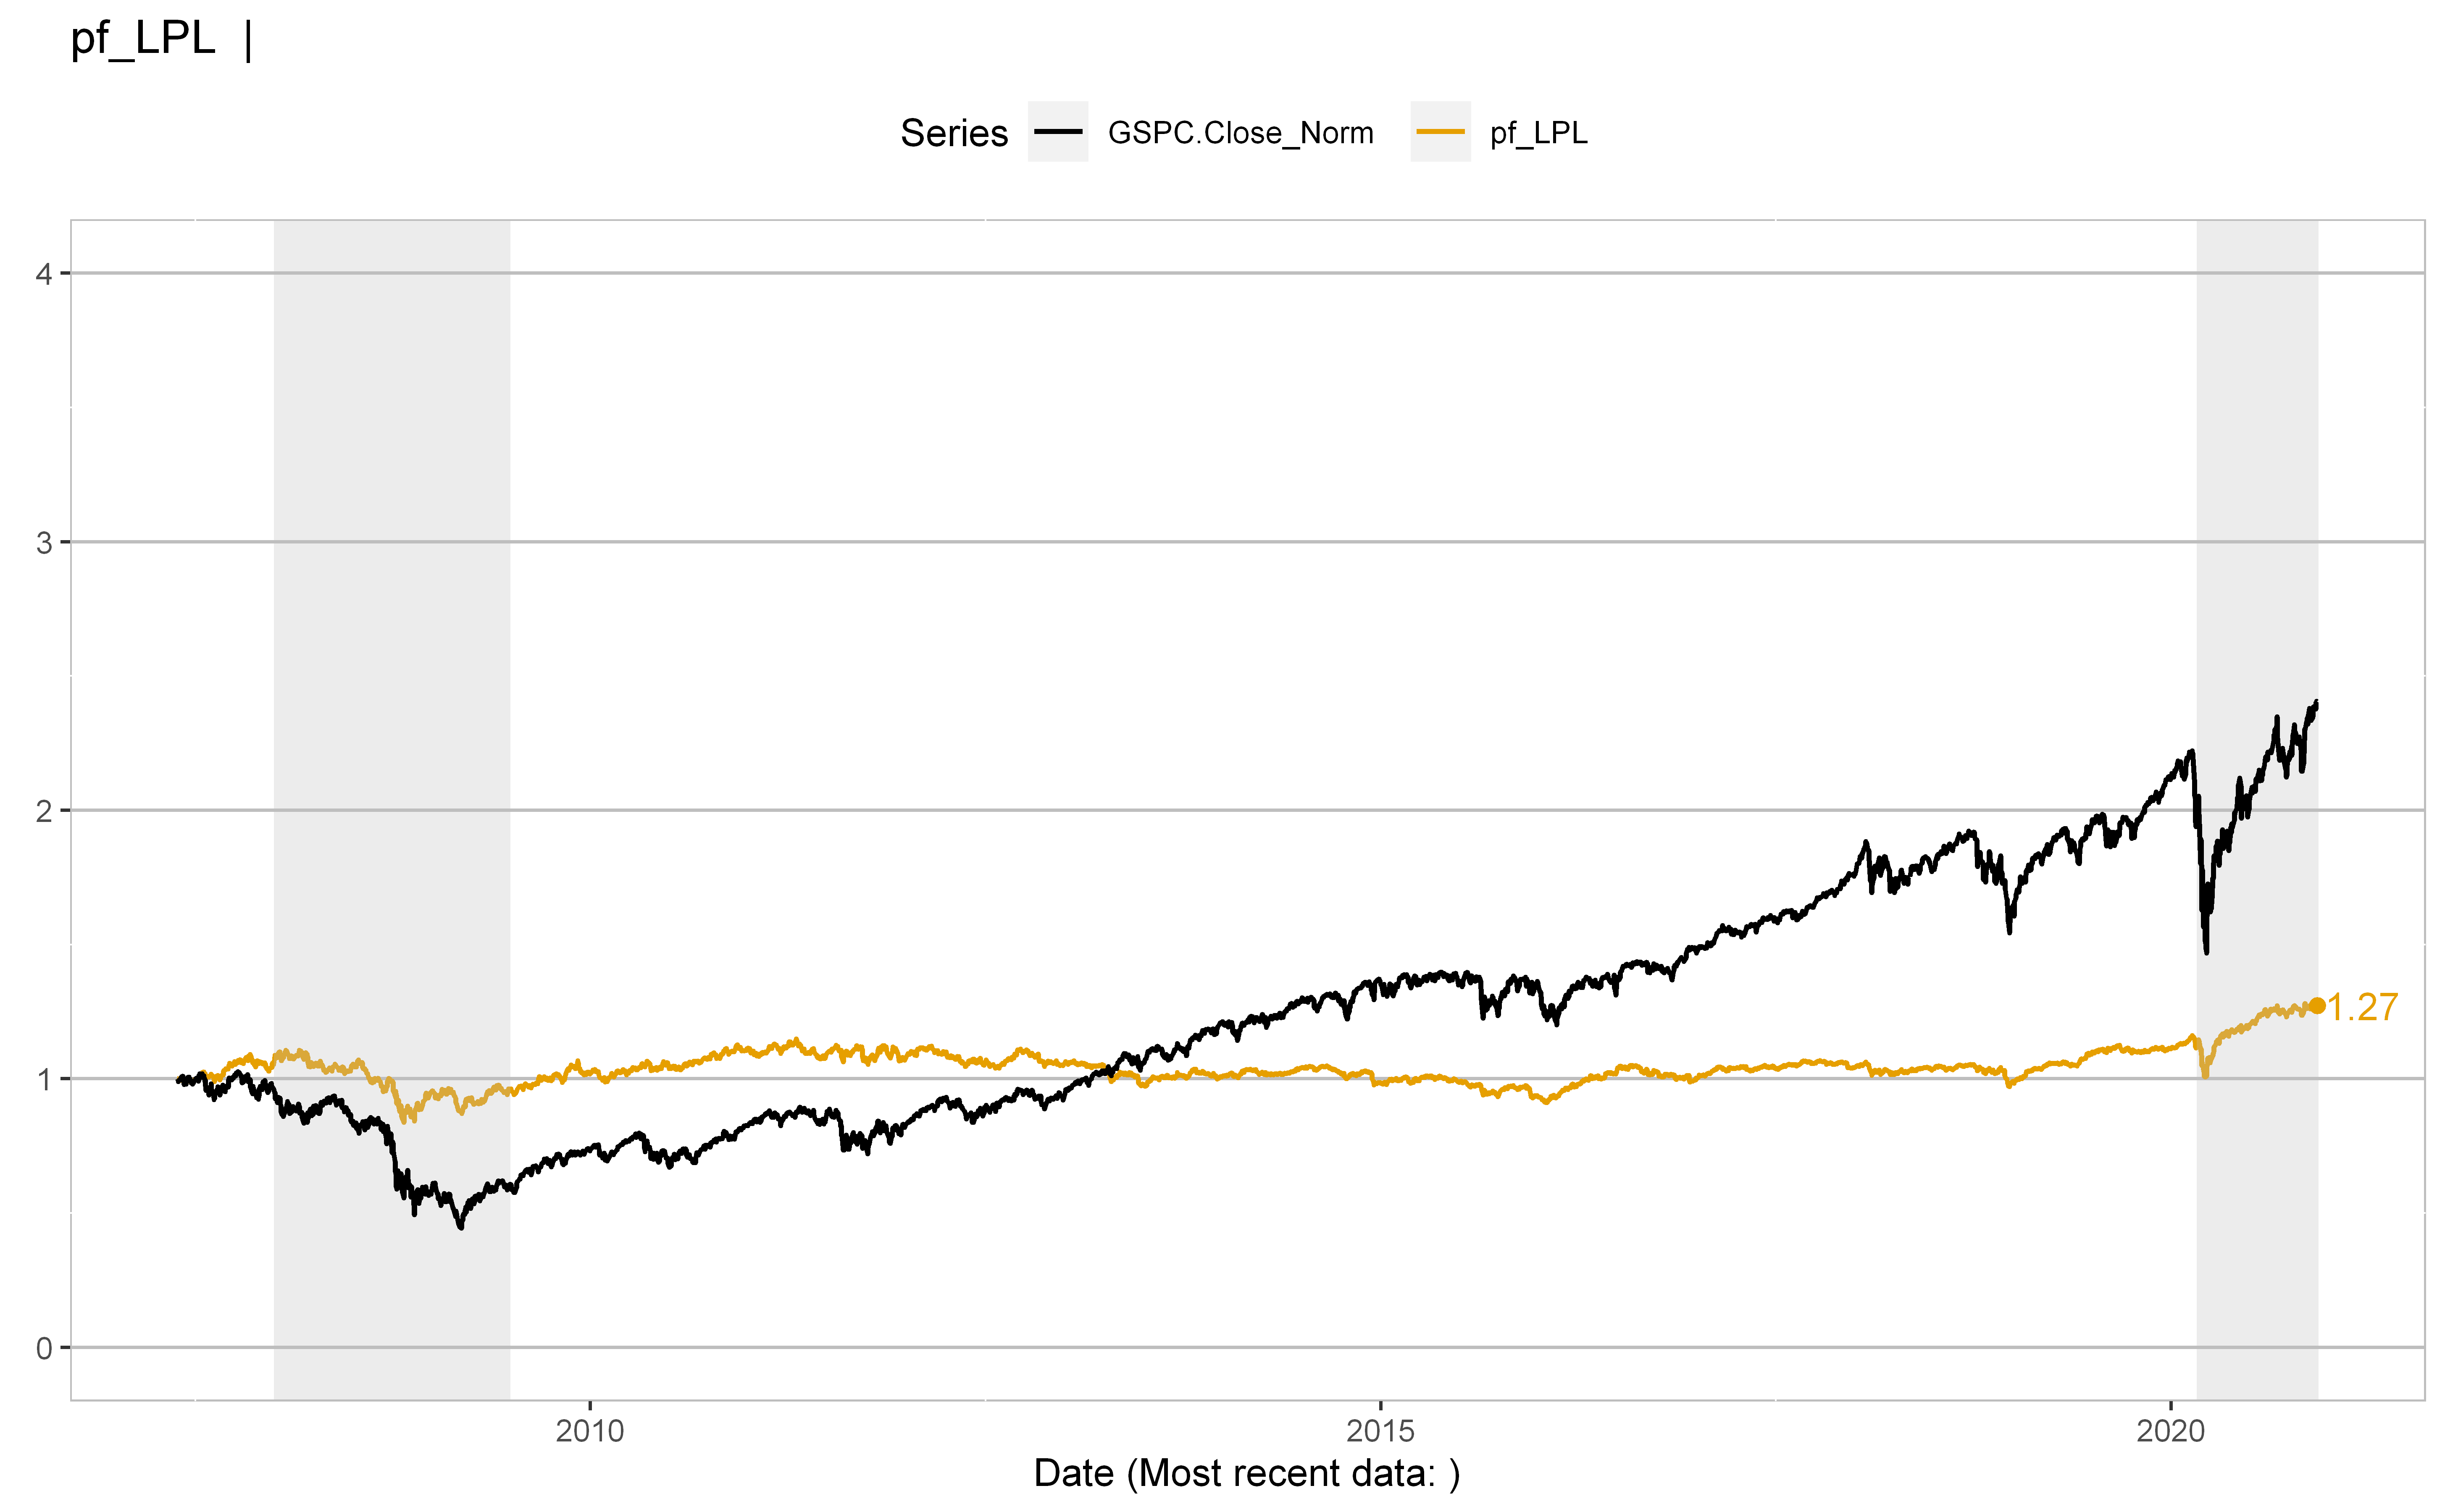

In [43]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay.legacy <- "pf_LPL"
ylim <- c(0, 4)
plotSingleBench(dfRecession, datay.legacy, ylim, df.symbols, df.data, string.analysis.start)

## Risk return analysis

This section plots the funds on return and volatility axis. An ideal fund would be in the upper left corner of the plot.

In [44]:
dfRR <- df.symbols[df.symbols[datay.legacy] > 0, ]
dfRR

,string.symbol,string.source,string.description,string.label.y,float.expense.ratio,date.series.start,date.series.end,Max030,Max180,ExpReturn,Volatility,pf_Roth_Legacy,pf_Roth_IRA,pf_LPL
,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<date>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,GSFTX,yahoo,Columbia Dividend Income Fund Institutional Class,Dollars,0.71,1998-03-04,2020-12-03,NA,NA,4.83049718,13.532403,0,0.0000000,0.11538462
24,VBIRX,yahoo,Vanguard Short-Term Bond Index Fund Admiral Shares,Dollars,0.07,2001-11-12,2020-12-03,NA,NA,0.66722212,1.677738,0,0.0000000,0.03846154
26,VFSUX,yahoo,Vanguard Short-Term Investment-Grade Fund Admiral Shares,Dollars,0.10,2001-02-12,2020-12-03,NA,NA,0.26286734,3.104439,0,0.0000000,0.03846154
27,LTUIX,yahoo,Thornburg Limited Term U.S. Government Fund Class I,Dollars,0.62,1996-07-05,2020-12-03,NA,NA,0.33252413,2.018869,0,0.0000000,0.03846154
28,PTTPX,yahoo,PIMCO Total Return Fund Class I-2,Dollars,0.81,2008-04-30,2020-12-03,NA,NA,-0.04172663,4.201701,0,0.0000000,0.03846154
29,NERYX,yahoo,Loomis Sayles Core Plus Bond Fund Class Y,Dollars,0.48,1994-12-30,2020-12-03,NA,NA,1.67655657,5.200329,0,0.0000000,0.03846154
30,STIGX,yahoo,Virtus Seix Core Bond Fund Class I,Dollars,0.50,1992-06-08,2020-12-03,NA,NA,0.76215597,3.921574,0,0.0000000,0.03846154
31,HLGAX,yahoo,JPMorgan Government Bond Fund Class I,Dollars,0.48,1993-02-08,2020-12-03,NA,NA,0.86777362,3.451181,0,0.0000000,0.03846154
32,FTRGX,yahoo,Federated Hermes Total Return Government Bond Fund Institutional Shares,Dollars,0.33,2014-06-18,2020-12-03,NA,NA,0.40597708,2.581308,0,0.0000000,0.03846154


In [45]:
rrData <- plotReturnVolatility(datay.legacy, df.data, df.symbols)

[1] "Failed to find efficiency boundary"
[1] "Volatility:  -5  |  55"
[1] "Returns:  -5  |  15"


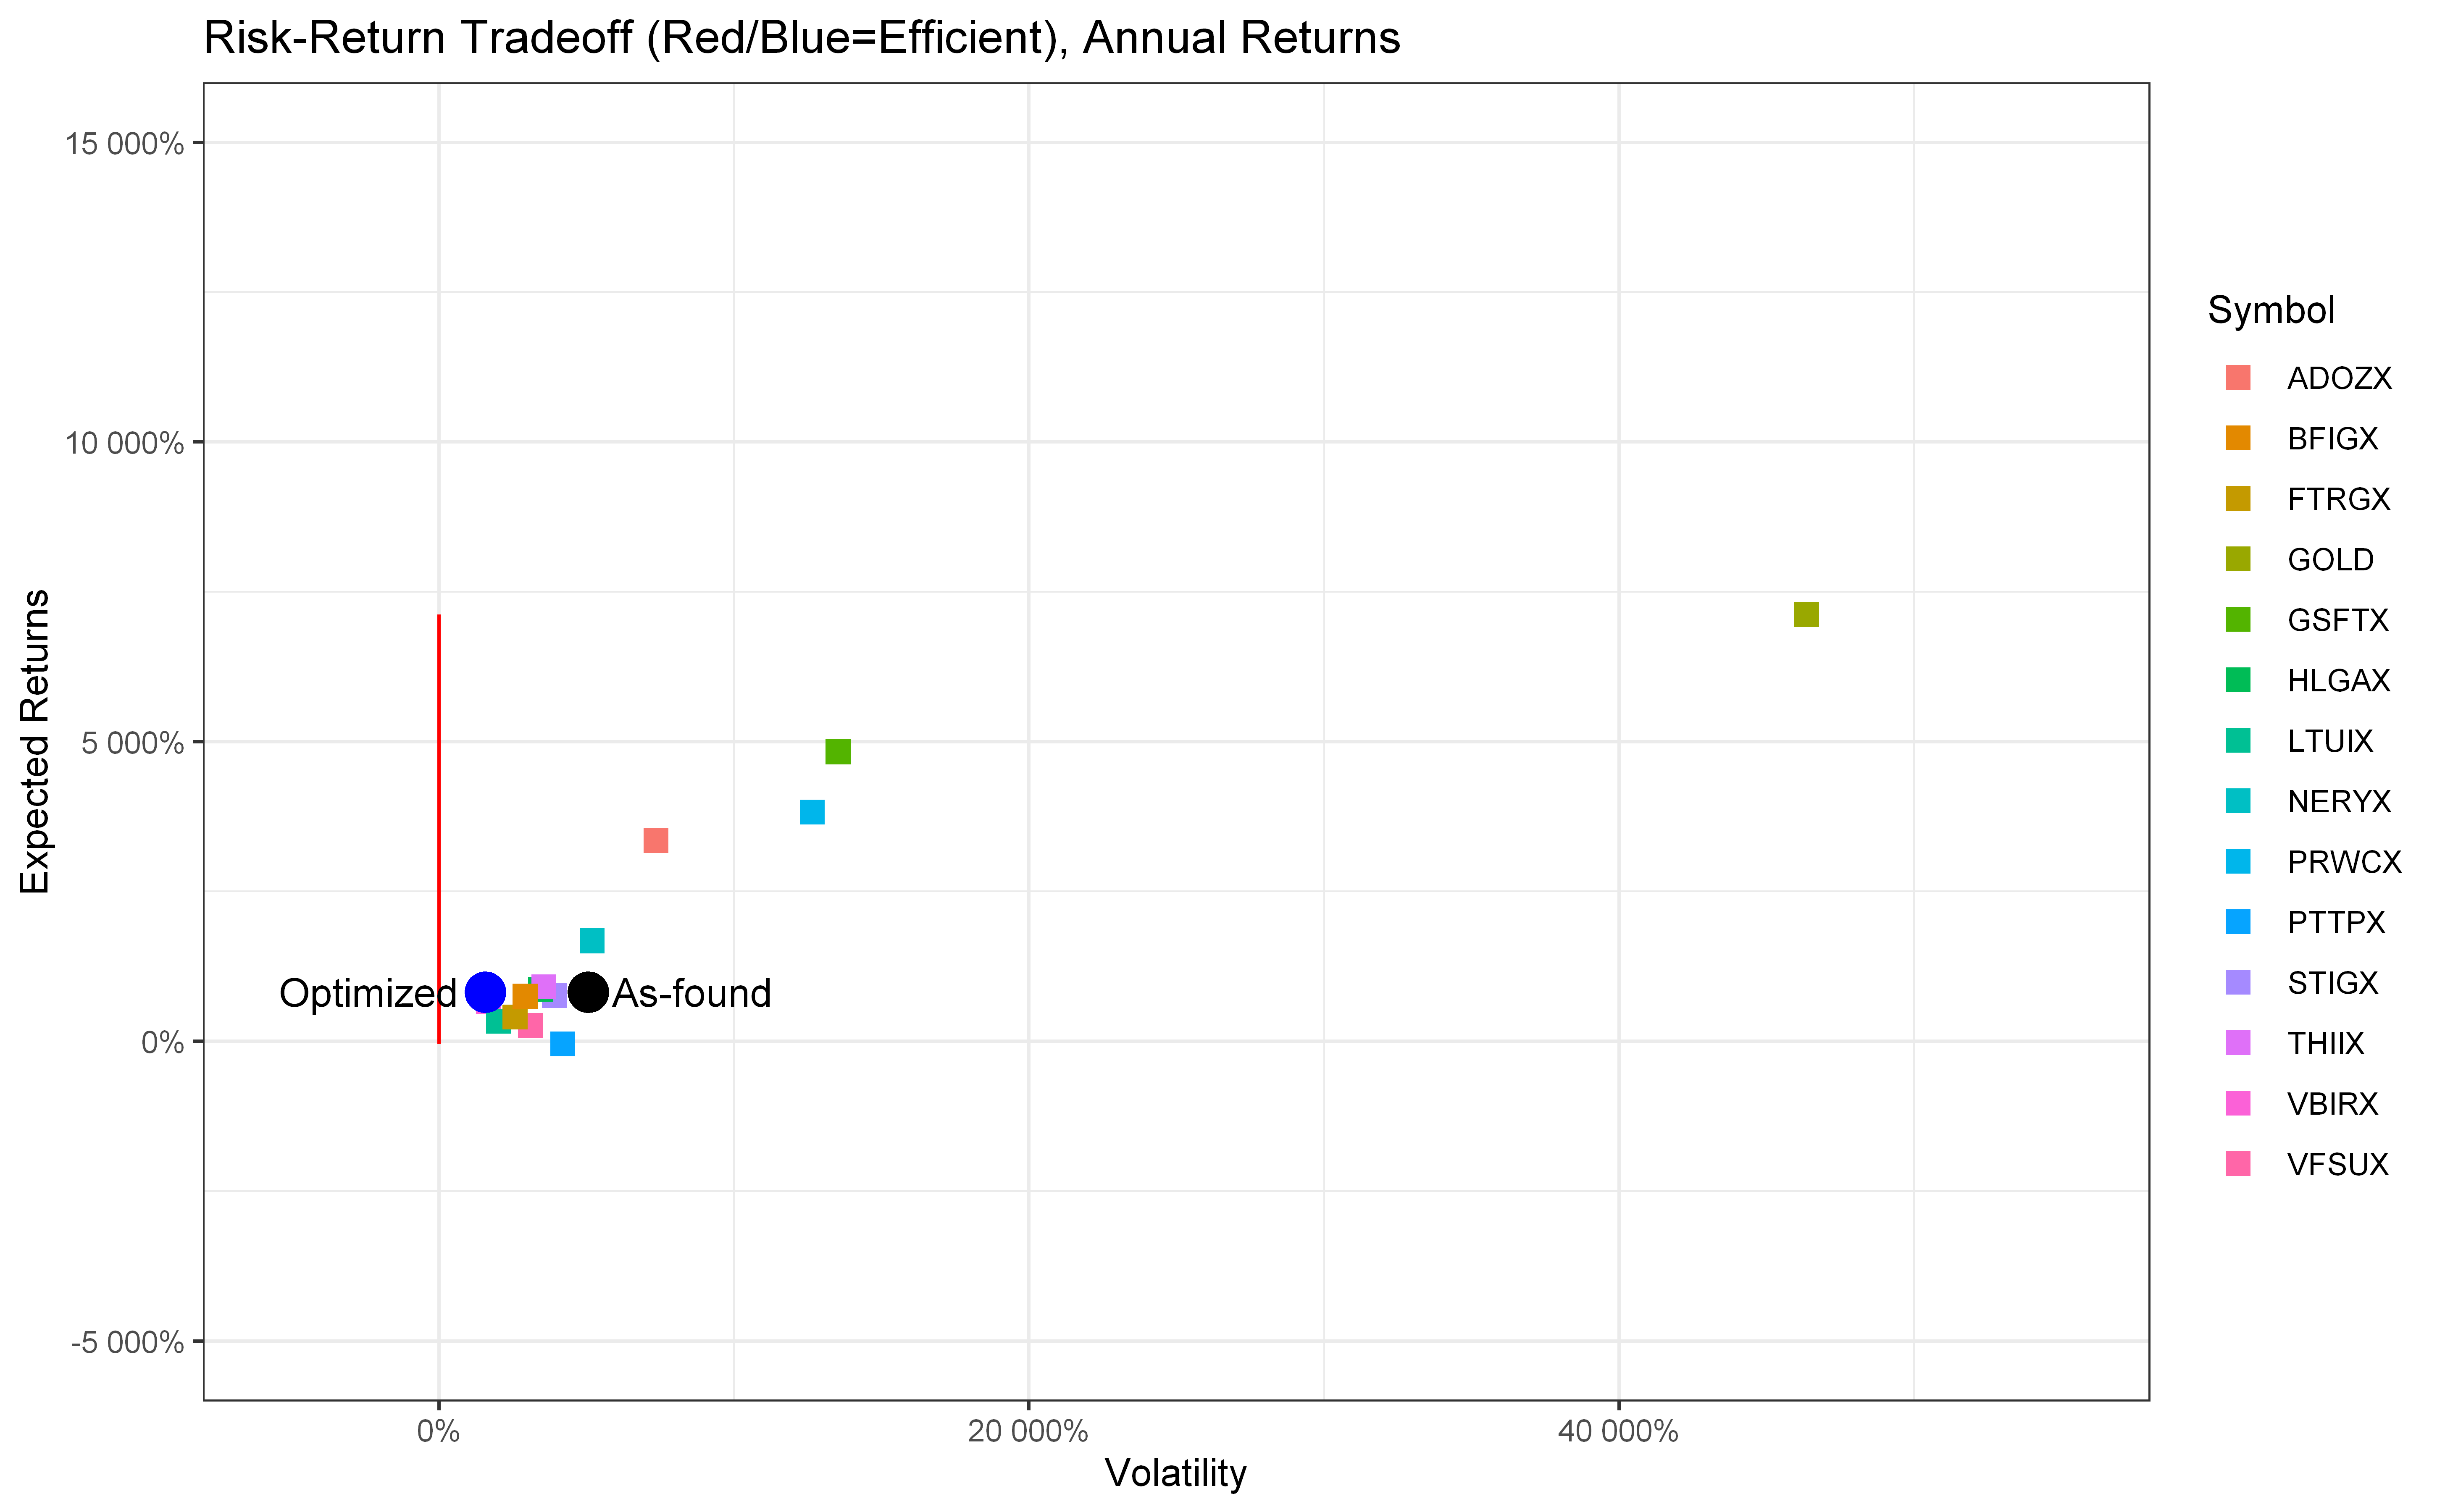

In [46]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
rrData[[2]]

This table shows the portfolio. Column `r datay.legacy` shows the inputted portfolio and `r paste(datay.legacy,"_Opt", sep="")` shows the portfolio with the same returns, but less risk.

In [47]:
tblPort(rrData, datay.legacy)  %>%
  as.character() %>%
  display_html()

,string.symbol,string.description,date.series.start,float.expense.ratio,pf_LPL,pf_LPL_Opt
18,GSFTX,Columbia Dividend Income Fund Institutional Class,1998-03-04,0.71,0.115,0.027
24,VBIRX,Vanguard Short-Term Bond Index Fund Admiral Shares,2001-11-12,0.07,0.038,0.619
26,VFSUX,Vanguard Short-Term Investment-Grade Fund Admiral Shares,2001-02-12,0.10,0.038,0.000
27,LTUIX,Thornburg Limited Term U.S. Government Fund Class I,1996-07-05,0.62,0.038,0.300
28,PTTPX,PIMCO Total Return Fund Class I-2,2008-04-30,0.81,0.038,0.000
29,NERYX,Loomis Sayles Core Plus Bond Fund Class Y,1994-12-30,0.48,0.038,0.000
30,STIGX,Virtus Seix Core Bond Fund Class I,1992-06-08,0.50,0.038,0.000
31,HLGAX,JPMorgan Government Bond Fund Class I,1993-02-08,0.48,0.038,0.000
32,FTRGX,Federated Hermes Total Return Government Bond Fund Institutional Shares,2014-06-18,0.33,0.038,0.000
33,THIIX,Thornburg Limited Term Income Fund Class I,1996-07-05,0.49,0.038,0.000


In [48]:
tail(df.data)

,CPIAUCSL,USREC,UNRATE,CCSA,CCNSA,NPPTTL,U6RATE,PAYNSA,TABSHNO,HNONWPDPI,...,GDPSP500,RLGSP500,DJISP500,nyfed.recession,RecInit,RecInit_Smooth,pf_Roth_Legacy,pf_Roth_IRA,pf_LPL,pf_Roth_Legacy_Opt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-11-29,260.325,1,6.7,5520000,5240575,119715.3,12,144005,135435.2,649.8103,...,0.1714412,0.1097252,1.405164,0.1508078,0,0.005057166,2.385885,2.539311,1.266821,0
2020-11-30,260.325,1,6.7,5520000,5240575,119715.3,12,144005,135435.2,649.8103,...,0.1711778,0.1097763,1.400882,0.1508078,0,-0.003177300,2.382354,2.536766,1.267145,0
2020-12-01,260.325,1,6.7,5520000,5240575,119715.3,12,144005,135435.2,649.8103,...,0.1731072,0.1110094,1.409640,0.1410444,0,-0.007872025,2.409232,2.559794,1.273413,0
2020-12-02,260.325,1,6.7,5520000,5240575,119715.3,12,144005,135435.2,649.8103,...,0.1734173,0.1107202,1.412469,0.1374961,0,-0.006068633,2.413781,2.560025,1.273539,0
2020-12-03,260.325,1,6.7,5520000,5240575,119715.3,12,144005,135435.2,649.8103,...,0.1733090,0.1106823,1.416522,0.1374961,0,-0.004740932,2.412720,2.561233,1.272300,0
2020-12-04,260.325,1,6.7,5520000,5240575,119715.3,12,144005,135435.2,649.8103,...,0.1733090,0.1106823,1.416522,0.1374961,0,-0.003491795,2.412720,2.561233,1.272300,0
